# Paper Figures: Figure 5 - Lagged Correlation Analysis

Cross-correlation analysis between dopamine (photometry AUC) and behavior (time moving) across different time lags. Determines optimal lag for each animal where correlation is strongest.

In [96]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys

# Register dill/pathlib compatibility shim BEFORE importing dill
sys.path.insert(0, str(Path("../src").resolve()))
from pickle_compat import enable_dill_pathlib_compat
enable_dill_pathlib_compat()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dill
from scipy.stats import pearsonr

from figure_config import (
    configure_matplotlib, COLORS,
    DATAFOLDER, RESULTSFOLDER, FIGSFOLDER,
    SAVE_FIGS
)
from figure_plotting import save_figure

from utils import recalculate_time_moving

# Configure matplotlib
configure_matplotlib()
colors = COLORS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
# Load assembled data from figure_4 preprocessing
assembled_data_path = DATAFOLDER / "assembled_data.pickle"

with open(assembled_data_path, "rb") as f:
    data = dill.load(f)

x_array = data["x_array"]
snips_movement = data["snips_movement"]

x_array = recalculate_time_moving(x_array, snips_movement, threshold=0.01)

# Get the deplete + 45NaCl animals
subset_condition = (
    x_array
    .query("condition == 'deplete' & infusiontype == '45NaCl'")
    .reset_index(drop=True)
    .sort_values(['id', 'trial'])
)

subset_aligned = (
    subset_condition
    .dropna(subset=['trial_aligned'])
    .reset_index(drop=True)
    .sort_values(['id', 'trial'])
)


## Helper Functions

In [98]:
def include_only_complete_trials(df, group_col="trial_aligned", n_required=8):
    """Filter df to include only groups with at least n_required entries."""
    return (
        df
        .groupby(group_col, group_keys=False)
        .filter(lambda g: len(g) >= n_required)
        .copy()
    )


def compute_lagged_pearson(dopamine, behavior, lag_range=(-5, 5), min_overlap=10):
    """Compute Pearson r for each lag in the requested window."""
    n_trials = len(dopamine)
    lags = np.arange(-(n_trials - 1), n_trials)

    valid_lag_mask = (lags >= lag_range[0]) & (lags <= lag_range[1])
    valid_lags = lags[valid_lag_mask]

    rows = []
    for lag in valid_lags:
        overlap = len(dopamine) - abs(lag)
        if overlap < min_overlap:
            rows.append({"lag_trials": lag, "pearson_r": np.nan, "n_samples": overlap})
            continue

        if lag < 0:
            dop_lag = dopamine[:lag]
            behav_lag = behavior[-lag:]
        elif lag > 0:
            dop_lag = dopamine[lag:]
            behav_lag = behavior[:-lag]
        else:
            dop_lag = dopamine
            behav_lag = behavior

        try:
            r, _ = pearsonr(dop_lag, behav_lag)
        except:
            r = np.nan

        rows.append({"lag_trials": lag, "pearson_r": r, "n_samples": len(dop_lag)})

    return pd.DataFrame(rows)


def select_optimal_lag(dopamine, behavior, lag_df):
    """Select lag with maximum |r| and compute p-value at that lag."""
    valid = lag_df["pearson_r"].notna()
    if not valid.any():
        return {
            "lag_trials": np.nan,
            "pearson_r": np.nan,
            "p_value": np.nan,
            "n_samples": np.nan,
        }

    best_idx = lag_df.loc[valid, "pearson_r"].abs().idxmax()
    best_lag = int(lag_df.loc[best_idx, "lag_trials"])
    best_r = lag_df.loc[best_idx, "pearson_r"]

    if best_lag < 0:
        dop_lag = dopamine[:best_lag]
        behav_lag = behavior[-best_lag:]
    elif best_lag > 0:
        dop_lag = dopamine[best_lag:]
        behav_lag = behavior[:-best_lag]
    else:
        dop_lag = dopamine
        behav_lag = behavior

    try:
        _, p_value = pearsonr(dop_lag, behav_lag)
    except:
        p_value = np.nan

    return {
        "lag_trials": best_lag,
        "pearson_r": best_r,
        "p_value": p_value,
        "n_samples": len(dop_lag),
    }


def compute_optimal_lag_correlation(dopamine, behavior, lag_range=(-5, 5), min_overlap=10):
    """Compute optimal lag correlation between two signals using Pearson r."""
    lag_df = compute_lagged_pearson(
        dopamine,
        behavior,
        lag_range=lag_range,
        min_overlap=min_overlap,
    )
    return select_optimal_lag(dopamine, behavior, lag_df)


def plot_lag_histogram(
    lag_values,
    lag_range,
    title,
    colors,
    save_figs,
    save_name,
    figsfolder,
    legend_loc,
    figsize=(3, 3),
    pos_color='#d34d4d',
    neg_color='#3b6fb6',
    zero_color='#9a9a9a',
):
    """Plot lag histogram with sign-based bar colors and centered integer bins."""
    f, ax = plt.subplots(figsize=figsize)

    tick_min, tick_max = lag_range[0], lag_range[1]
    ticks = np.arange(tick_min, tick_max + 1, 1)
    bins = np.arange(tick_min - 0.5, tick_max + 1.5, 1)

    counts, bin_edges, patches = ax.hist(
        lag_values,
        bins=bins,
        edgecolor='k',
        linewidth=1.5,
    )

    for left, right, patch in zip(bin_edges[:-1], bin_edges[1:], patches):
        center = 0.5 * (left + right)
        if center == 0:
            patch.set_facecolor(zero_color)
        elif center > 0:
            patch.set_facecolor(pos_color)
        else:
            patch.set_facecolor(neg_color)
        patch.set_alpha(0.8)

    mean_val = np.nanmean(lag_values)
    median_val = np.nanmedian(lag_values)

    ax.axvline(mean_val, color=colors[0], linestyle='--', linewidth=2.5,
              label=f'Mean: {mean_val:.2f} trials')
    ax.axvline(median_val, color=colors[1], linestyle='--', linewidth=2,
              label=f'Median: {median_val:.1f} trials')
    ax.axvline(0, color='gray', linestyle=':', linewidth=1, alpha=0.5)

    ax.set_xlabel('Lag (trials)', fontsize=11)
    ax.set_ylabel('Count (n animals)', fontsize=11)
    ax.set_title(title, fontsize=12)
    ax.set_xticks([lag_range[0], 0, lag_range[1]])
    ax.legend(fontsize=10, loc=legend_loc, frameon=False)
    sns.despine(ax=ax)

    if save_figs:
        save_figure(f, save_name, figsfolder)

    plt.show()
    return f, ax

## Figure 5A: Cross-Correlation Analysis (Full Data, -10 to +10 trials)

Compute cross-correlation across all trials and animals to see correlation patterns without transition alignment.

In [99]:
# Compute optimal lag for each animal (full data, -10 to +10 trials)
lag_range = (-10, 10)

cross_corr_results_full = []

subset_condition = x_array.query("condition == 'deplete' & infusiontype == '45NaCl'")
animals_full = subset_condition.id.unique()

for animal in animals_full:
    # Get this animal's data for all trials, sorted by trial
    animal_data = (
        subset_condition
        .query("id == @animal")
        .sort_values('trial')
    )
    
    if len(animal_data) < 5:
        print(f"Warning: {animal} has {len(animal_data)} trials in window - skipping")
        continue
    
    # Extract and normalize signals
    dopamine_auc = animal_data['auc_snips'].values
    time_moving = animal_data['time_moving'].values
    
    dopamine_norm = (dopamine_auc - dopamine_auc.min()) / (dopamine_auc.max() - dopamine_auc.min() + 1e-10)
    behavior_norm = (time_moving - time_moving.min()) / (time_moving.max() - time_moving.min() + 1e-10)
    
    # Compute optimal lag
    result = compute_optimal_lag_correlation(dopamine_norm, behavior_norm, lag_range=lag_range)
    result['animal'] = animal
    result['n_trials'] = len(animal_data)
    result['analysis_type'] = 'full_data'
    
    cross_corr_results_full.append(result)

cross_corr_df_full = pd.DataFrame(cross_corr_results_full)

print("\nFull Data Lagged Correlation (Dopamine AUC vs Time Moving)")
print("Window: all trials (optimal lag selected by max |Pearson r|)")
print(cross_corr_df_full[['animal', 'lag_trials', 'pearson_r', 'p_value', 'n_trials']].to_string(index=False))
print(f"\nLag Summary (in trials):")
print(f"  Mean lag: {cross_corr_df_full['lag_trials'].mean():.2f} trials")
print(f"  Median lag: {cross_corr_df_full['lag_trials'].median():.2f} trials")
print(f"  Std: {cross_corr_df_full['lag_trials'].std():.2f} trials")
print(f"\nMean Pearson correlation at optimal lag: {cross_corr_df_full['pearson_r'].mean():.3f}")


Full Data Lagged Correlation (Dopamine AUC vs Time Moving)
Window: all trials (optimal lag selected by max |Pearson r|)
animal  lag_trials  pearson_r      p_value  n_trials
  PB26          -4  -0.483684 7.625135e-04        49
  PB27          -4   0.362671 1.434893e-02        49
  PB30         -10  -0.496707 1.298015e-03        49
  PB31          -2  -0.774240 1.729434e-10        49
  PB46           0  -0.534945 7.497207e-05        49
  PB48           7  -0.427431 4.752480e-03        49
  PB71           0  -0.359519 1.117685e-02        49
  PB72          -4  -0.607971 9.439068e-06        49
  PB73          -1  -0.586096 1.203964e-05        49
  PB75           0  -0.622288 1.810496e-06        49

Lag Summary (in trials):
  Mean lag: -1.80 trials
  Median lag: -1.50 trials
  Std: 4.34 trials

Mean Pearson correlation at optimal lag: -0.453


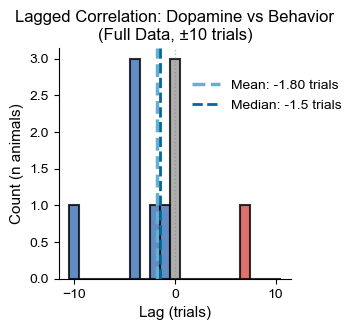

(<Figure size 300x300 with 1 Axes>,
 <Axes: title={'center': 'Lagged Correlation: Dopamine vs Behavior\n(Full Data, ±10 trials)'}, xlabel='Lag (trials)', ylabel='Count (n animals)'>)

In [100]:
# Plot histogram of lags (full data)
plot_lag_histogram(
    cross_corr_df_full['lag_trials'],
    lag_range=lag_range,
    title='Lagged Correlation: Dopamine vs Behavior\n(Full Data, ±10 trials)',
    colors=colors,
    save_figs=SAVE_FIGS,
    save_name='fig5b_lagged_correlation_full',
    figsfolder=FIGSFOLDER,
    legend_loc=(0.55, 0.7),
)

## Individual Animals: Lag Profiles

## Figure 5B: Cross-Correlation Analysis (Transition-Aligned, -10 to +10 trials)

Compute cross-correlation within ±10 trials of transition to determine temporal lag between signals for each animal.

In [101]:
# Compute optimal lag for each animal (transition-aligned data, -5 to +5 trials)
data_to_correlate = subset_aligned
animals = data_to_correlate.id.unique()
lag_range=(-10, 10)

cross_corr_results = []

for animal in animals:
    # Get this animal's data restricted to -15 to +15 trials, sorted by trial_aligned
    animal_data = include_only_complete_trials(data_to_correlate).query(
        "id == @animal & trial_aligned >= -15 & trial_aligned <= 15"
    ).sort_values('trial_aligned')
    
    if len(animal_data) < 5:
        print(f"Warning: {animal} has {len(animal_data)} trials in window - skipping")
        continue
    
    # Extract and normalize signals
    dopamine_auc = animal_data['auc_snips'].values
    time_moving = animal_data['time_moving'].values
    
    dopamine_norm = (dopamine_auc - dopamine_auc.min()) / (dopamine_auc.max() - dopamine_auc.min() + 1e-10)
    behavior_norm = (time_moving - time_moving.min()) / (time_moving.max() - time_moving.min() + 1e-10)
    
    # Compute optimal lag
    result = compute_optimal_lag_correlation(dopamine_norm, behavior_norm, lag_range=lag_range)
    result['animal'] = animal
    result['n_trials'] = len(animal_data)
    result['analysis_type'] = 'transition_aligned'
    
    cross_corr_results.append(result)

cross_corr_df = pd.DataFrame(cross_corr_results)

print("\nTransition-Aligned Lagged Correlation (Dopamine AUC vs Time Moving)")
print("Window: -5 to +5 trials from transition (optimal lag selected by max |Pearson r|)")
print(cross_corr_df[['animal', 'lag_trials', 'pearson_r', 'p_value', 'n_trials']].to_string(index=False))
print(f"\nLag Summary (in trials):")
print(f"  Mean lag: {cross_corr_df['lag_trials'].mean():.2f} trials")
print(f"  Median lag: {cross_corr_df['lag_trials'].median():.2f} trials")
print(f"  Std: {cross_corr_df['lag_trials'].std():.2f} trials")
print(f"\nMean Pearson correlation at optimal lag: {cross_corr_df['pearson_r'].mean():.3f}")


Transition-Aligned Lagged Correlation (Dopamine AUC vs Time Moving)
Window: -5 to +5 trials from transition (optimal lag selected by max |Pearson r|)
animal  lag_trials  pearson_r  p_value  n_trials
  PB26           2  -0.532696 0.006116        27
  PB30         -10  -0.475036 0.053984        27
  PB31          -2  -0.646757 0.000476        27
  PB46           8  -0.390120 0.098690        27
  PB71         -10  -0.767274 0.000325        27
  PB72           6  -0.647985 0.001491        27
  PB73          -1  -0.676091 0.000150        27
  PB75           0  -0.686971 0.000076        27

Lag Summary (in trials):
  Mean lag: -0.88 trials
  Median lag: -0.50 trials
  Std: 6.58 trials

Mean Pearson correlation at optimal lag: -0.603


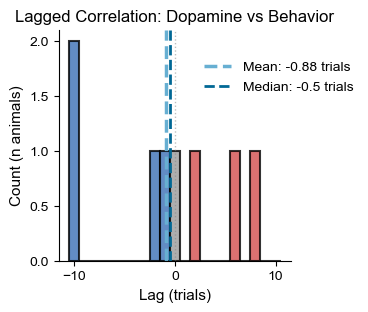

(<Figure size 300x300 with 1 Axes>,
 <Axes: title={'center': 'Lagged Correlation: Dopamine vs Behavior'}, xlabel='Lag (trials)', ylabel='Count (n animals)'>)

In [102]:
# Plot histogram of lags (transition-aligned)
plot_lag_histogram(
    cross_corr_df['lag_trials'],
    lag_range=lag_range,
    title='Lagged Correlation: Dopamine vs Behavior',
    colors=colors,
    save_figs=SAVE_FIGS,
    save_name='fig5a_lagged_correlation_transition',
    figsfolder=FIGSFOLDER,
    legend_loc=(0.6, 0.7),
)

PB48


C:\Users\jmc010\AppData\Local\Temp\ipykernel_25104\2569868535.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


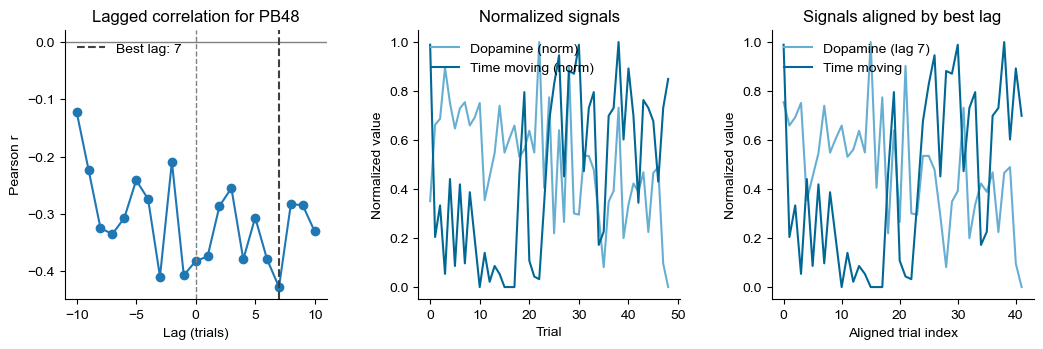

In [106]:
# Single animal lag plot (match optimal-lag calculations)
animal_to_plot = 'PB48'
print(animal_to_plot)

lag_range = (-10, 10)
min_overlap = 10

animal_data = (
    subset_condition
    .query("id == @animal_to_plot")
    .sort_values("trial")
)

dopamine_auc = animal_data["auc_snips"].to_numpy()
time_moving = animal_data["time_moving"].to_numpy()

dopamine_norm = (dopamine_auc - dopamine_auc.min()) / (dopamine_auc.max() - dopamine_auc.min() + 1e-10)
behavior_norm = (time_moving - time_moving.min()) / (time_moving.max() - time_moving.min() + 1e-10)

lag_r_df = compute_lagged_pearson(
    dopamine_norm,
    behavior_norm,
    lag_range=lag_range,
    min_overlap=min_overlap,
)

best = select_optimal_lag(dopamine_norm, behavior_norm, lag_r_df)
best_lag = best["lag_trials"]

fig, axes = plt.subplots(1, 3, figsize=(12.5, 3.5), gridspec_kw={"wspace": 0.35})

axes[0].plot(lag_r_df["lag_trials"], lag_r_df["pearson_r"], marker="o")
axes[0].axhline(0, color="0.5", linewidth=1)
axes[0].axvline(0, color="0.5", linewidth=1, linestyle="--")
if np.isfinite(best_lag):
    axes[0].axvline(best_lag, color="0.25", linewidth=1.5, linestyle="--",
                    label=f"Best lag: {int(best_lag)}")
    axes[0].legend(frameon=False)
axes[0].set_xlabel("Lag (trials)")
axes[0].set_ylabel("Pearson r")
axes[0].set_title(f"Lagged correlation for {animal_to_plot}")

trial_idx = np.arange(len(dopamine_norm))
axes[1].plot(trial_idx, dopamine_norm, label="Dopamine (norm)", color=colors[0])
axes[1].plot(trial_idx, behavior_norm, label="Time moving (norm)", color=colors[1])
axes[1].set_xlabel("Trial")
axes[1].set_ylabel("Normalized value")
axes[1].set_title("Normalized signals")
axes[1].legend(frameon=False)

if np.isfinite(best_lag):
    if best_lag < 0:
        dop_lag = dopamine_norm[:best_lag]
        behav_lag = behavior_norm[-best_lag:]
    elif best_lag > 0:
        dop_lag = dopamine_norm[best_lag:]
        behav_lag = behavior_norm[:-best_lag]
    else:
        dop_lag = dopamine_norm
        behav_lag = behavior_norm

    aligned_idx = np.arange(len(dop_lag))
    axes[2].plot(aligned_idx, dop_lag, label=f"Dopamine (lag {int(best_lag)})", color=colors[0])
    axes[2].plot(aligned_idx, behav_lag, label="Time moving", color=colors[1])
    axes[2].set_xlabel("Aligned trial index")
    axes[2].set_ylabel("Normalized value")
    axes[2].set_title("Signals aligned by best lag")
    axes[2].legend(frameon=False)
else:
    axes[2].axis("off")
    axes[2].set_title("No valid lag")

sns.despine(fig=fig)
plt.tight_layout()
plt.show()

# lag_r_df

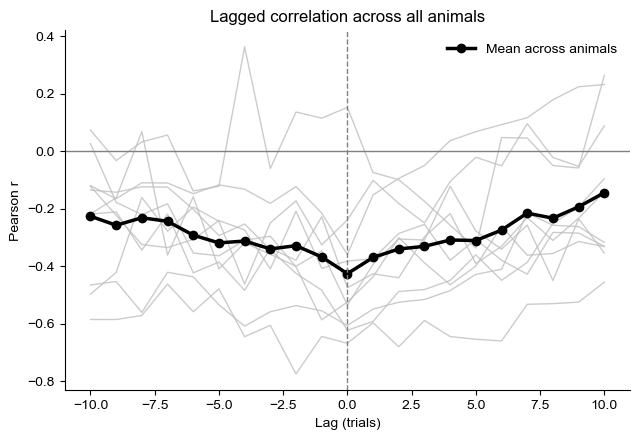

,lag_trials,pearson_r,n_samples,animal
0,-10,-0.218684,39,PB26
1,-9,-0.211303,40,PB26
2,-8,-0.343852,41,PB26
3,-7,-0.218519,42,PB26
4,-6,-0.422825,43,PB26


In [104]:
# Multi-animal overlay: lagged Pearson r for all animals + mean
lag_range = (-10, 10)
min_overlap = 10

all_lag_dfs = []
for animal_name in sorted(animals_full):
    animal_data = (
        subset_condition
        .query("id == @animal_name")
        .sort_values("trial")
    )

    dopamine_auc = animal_data["auc_snips"].to_numpy()
    time_moving = animal_data["time_moving"].to_numpy()

    dopamine_norm = (dopamine_auc - dopamine_auc.min()) / (dopamine_auc.max() - dopamine_auc.min() + 1e-10)
    behavior_norm = (time_moving - time_moving.min()) / (time_moving.max() - time_moving.min() + 1e-10)

    lag_df = compute_lagged_pearson(
        dopamine_norm,
        behavior_norm,
        lag_range=lag_range,
        min_overlap=min_overlap,
    )
    lag_df["animal"] = animal_name

    all_lag_dfs.append(lag_df)

lag_r_all_df = pd.concat(all_lag_dfs, ignore_index=True)
lag_r_mean_df = lag_r_all_df.groupby("lag_trials", as_index=False)["pearson_r"].mean()

plt.figure(figsize=(6.5, 4.5))
for animal_name, df_animal in lag_r_all_df.groupby("animal"):
    plt.plot(df_animal["lag_trials"], df_animal["pearson_r"], color="0.75", linewidth=1, alpha=0.8)

plt.plot(
    lag_r_mean_df["lag_trials"],
    lag_r_mean_df["pearson_r"],
    color="black",
    linewidth=2.5,
    marker="o",
    label="Mean across animals",
)

plt.axhline(0, color="0.5", linewidth=1)
plt.axvline(0, color="0.5", linewidth=1, linestyle="--")
plt.xlabel("Lag (trials)")
plt.ylabel("Pearson r")
plt.title("Lagged correlation across all animals")
plt.legend(frameon=False)
sns.despine()
plt.tight_layout()

if SAVE_FIGS:
    save_figure(plt.gcf(), "fig5_lagged_correlation_overlay", FIGSFOLDER)

plt.show()

lag_r_all_df.head()

## Diagnostic: Individual Animal Lag Selection

## Grid Search: Optimal Threshold and Lag Exploration

Explore parameter space to find optimal combination of time_moving threshold and lag for maximizing correlation between dopamine and behavior.

In [75]:
# Import the utility function for recalculating time_moving
from utils import recalculate_time_moving

# Load movement snips from the assembled data
snips_movement = data["snips_movement"]

# Define parameter grids
lag_range = (-10, 10)
threshold_range = np.linspace(0.005, 0.10, 20)  # 20 different thresholds from 0.005 to 0.10
min_overlap = 10

# for testing
# lag_range = (-2, 2) # for testing
# threshold_range = np.array([0.02, 0.2]) # for testing

print(f"Grid search parameters:")
print(f"  Lag range: {lag_range}")
print(f"  Number of threshold values: {len(threshold_range)}")
print(f"  Threshold range: [{threshold_range.min():.4f}, {threshold_range.max():.4f}]")
print(f"  Minimum overlap: {min_overlap} trials")
print(f"\nMovement snips shape: {snips_movement.shape}")
print(f"Full data shape: {subset_condition.shape}")

Grid search parameters:
  Lag range: (-10, 10)
  Number of threshold values: 20
  Threshold range: [0.0050, 0.1000]
  Minimum overlap: 10 trials

Movement snips shape: (1960, 200)
Full data shape: (490, 19)


In [ ]:
# Perform grid search: vary threshold and lag, compute optimal correlation for each combination
grid_results = []

for threshold in threshold_range:
        
    # Recalculate time_moving with this threshold
    x_array_with_new_threshold = recalculate_time_moving(
        x_array,
        snips_movement,
        threshold=threshold
    )

    subset_with_new_threshold = (x_array_with_new_threshold
                                 .query("condition == 'deplete' and infusiontype == '45NaCl'")
                                 )
    
    # For each animal, compute lagged correlations and find best lag
    for animal in animals_full:
        animal_data = (
            subset_with_new_threshold
            .query("id == @animal")
            .reset_index(drop=True)
        )
        
        if len(animal_data) < min_overlap * 2:
            continue
            
        # Extract signals
        dopamine_auc = animal_data['auc_snips'].values
        time_moving = animal_data['time_moving'].values
        
        # Normalize signals
        dopamine_norm = (dopamine_auc - dopamine_auc.min()) / (dopamine_auc.max() - dopamine_auc.min() + 1e-10)
        behavior_norm = (time_moving - time_moving.min()) / (time_moving.max() - time_moving.min() + 1e-10)
        
        # Compute lagged correlations
        lag_df = compute_lagged_pearson(dopamine_norm, behavior_norm, lag_range=lag_range, min_overlap=min_overlap)
        
        # Find best lag
        if len(lag_df) > 0:
            best_lag_info = select_optimal_lag(dopamine_norm, behavior_norm, lag_df)
            print(best_lag_info)
            best_lag = best_lag_info['lag_trials']
            best_r = best_lag_info['pearson_r']
            best_p = best_lag_info['p_value']
            
            grid_results.append({
                'animal': animal,
                'threshold': threshold,
                'best_lag': best_lag,
                'best_r': best_r,
                'best_abs_r': abs(best_r),
                'pvalue': best_p
            })

# Convert to DataFrame
grid_df = pd.DataFrame(grid_results)

print(f"Grid search complete!")
print(f"  Total combinations explored: {len(threshold_range)} thresholds × {len(animals_full)} animals = {len(grid_df)} results")
print(f"\nBest overall correlation:")
best_overall = grid_df.loc[grid_df['best_abs_r'].idxmax()]
print(f"  Animal: {best_overall['animal']}")
print(f"  Threshold: {best_overall['threshold']:.4f}")
print(f"  Lag: {int(best_overall['best_lag'])} trials")
print(f"  Pearson r: {best_overall['best_r']:.3f}")
print(f"  p-value: {best_overall['pvalue']:.4f}")

0.0
{'lag_trials': -2, 'pearson_r': np.float64(-0.6239063535149507), 'p_value': np.float64(2.793139261873864e-06), 'n_samples': 47}
{'lag_trials': 5, 'pearson_r': np.float64(-0.4473100587164154), 'p_value': np.float64(0.0023323285261766195), 'n_samples': 44}
{'lag_trials': -10, 'pearson_r': np.float64(-0.5986929183545382), 'p_value': np.float64(5.669590342752106e-05), 'n_samples': 39}
{'lag_trials': -1, 'pearson_r': np.float64(-0.7325212745805363), 'p_value': np.float64(3.259394094180895e-09), 'n_samples': 48}
{'lag_trials': 0, 'pearson_r': np.float64(-0.495100744472663), 'p_value': np.float64(0.00029846937481126963), 'n_samples': 49}
{'lag_trials': 7, 'pearson_r': np.float64(-0.381760079254969), 'p_value': np.float64(0.012605897498815645), 'n_samples': 42}
{'lag_trials': 8, 'pearson_r': np.float64(0.3097149416636552), 'p_value': np.float64(0.04877342876875948), 'n_samples': 41}
{'lag_trials': 0, 'pearson_r': np.float64(-0.6176330618027706), 'p_value': np.float64(2.272163531971229e-06)

C:\Users\jmc010\AppData\Local\Temp\ipykernel_25104\1731167227.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(dop_lag, behav_lag)
C:\Users\jmc010\AppData\Local\Temp\ipykernel_25104\1731167227.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(dop_lag, behav_lag)


{'lag_trials': 3, 'pearson_r': np.float64(-0.38605152943813303), 'p_value': np.float64(0.00805230498455374), 'n_samples': 46}
0.0
{'lag_trials': 2, 'pearson_r': np.float64(-0.43686566681770483), 'p_value': np.float64(0.0021388861719953715), 'n_samples': 47}
{'lag_trials': 8, 'pearson_r': np.float64(-0.4146068258379581), 'p_value': np.float64(0.007035196708908415), 'n_samples': 41}
{'lag_trials': -1, 'pearson_r': np.float64(-0.36075631115838036), 'p_value': np.float64(0.011769889995127708), 'n_samples': 48}
{'lag_trials': 8, 'pearson_r': np.float64(-0.2683046917975189), 'p_value': np.float64(0.08986393870942042), 'n_samples': 41}
{'lag_trials': 8, 'pearson_r': np.float64(-0.3487452104853378), 'p_value': np.float64(0.0254384708199167), 'n_samples': 41}
{'lag_trials': 9, 'pearson_r': np.float64(-0.3251039015039849), 'p_value': np.float64(0.040666601702222804), 'n_samples': 40}
{'lag_trials': nan, 'pearson_r': nan, 'p_value': nan, 'n_samples': nan}
{'lag_trials': -5, 'pearson_r': np.float6

C:\Users\jmc010\AppData\Local\Temp\ipykernel_25104\1731167227.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(dop_lag, behav_lag)
C:\Users\jmc010\AppData\Local\Temp\ipykernel_25104\1731167227.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(dop_lag, behav_lag)
C:\Users\jmc010\AppData\Local\Temp\ipykernel_25104\1731167227.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(dop_lag, behav_lag)


{'lag_trials': nan, 'pearson_r': nan, 'p_value': nan, 'n_samples': nan}
{'lag_trials': -5, 'pearson_r': np.float64(-0.427190262513047), 'p_value': np.float64(0.0038266440797912952), 'n_samples': 44}
{'lag_trials': 1, 'pearson_r': np.float64(-0.2185373973525917), 'p_value': np.float64(0.13562976577436506), 'n_samples': 48}
{'lag_trials': 0, 'pearson_r': np.float64(-0.3145388362059385), 'p_value': np.float64(0.027726602093076542), 'n_samples': 49}
0.0
{'lag_trials': 2, 'pearson_r': np.float64(-0.436125697366849), 'p_value': np.float64(0.0021807352539550914), 'n_samples': 47}
{'lag_trials': 8, 'pearson_r': np.float64(-0.37508496634163474), 'p_value': np.float64(0.015674949294960338), 'n_samples': 41}
{'lag_trials': -1, 'pearson_r': np.float64(-0.35978861500282455), 'p_value': np.float64(0.012014437552764625), 'n_samples': 48}
{'lag_trials': 2, 'pearson_r': np.float64(-0.2921199321478588), 'p_value': np.float64(0.04632271837229195), 'n_samples': 47}
{'lag_trials': -3, 'pearson_r': np.float

C:\Users\jmc010\AppData\Local\Temp\ipykernel_25104\1731167227.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(dop_lag, behav_lag)
C:\Users\jmc010\AppData\Local\Temp\ipykernel_25104\1731167227.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(dop_lag, behav_lag)
C:\Users\jmc010\AppData\Local\Temp\ipykernel_25104\1731167227.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(dop_lag, behav_lag)


{'lag_trials': 1, 'pearson_r': np.float64(-0.2185373973525917), 'p_value': np.float64(0.13562976577436506), 'n_samples': 48}
{'lag_trials': 7, 'pearson_r': np.float64(-0.33664262168762005), 'p_value': np.float64(0.029263238116595626), 'n_samples': 42}
0.0
{'lag_trials': 2, 'pearson_r': np.float64(-0.44442487188837165), 'p_value': np.float64(0.0017504196373451858), 'n_samples': 47}
{'lag_trials': -2, 'pearson_r': np.float64(0.35910274714393914), 'p_value': np.float64(0.013179062679290294), 'n_samples': 47}
{'lag_trials': -1, 'pearson_r': np.float64(-0.3743130404049455), 'p_value': np.float64(0.00876723885730063), 'n_samples': 48}
{'lag_trials': 4, 'pearson_r': np.float64(-0.2840755849665851), 'p_value': np.float64(0.05860035470444629), 'n_samples': 45}
{'lag_trials': -5, 'pearson_r': np.float64(-0.27403371386337916), 'p_value': np.float64(0.07185486110823877), 'n_samples': 44}
{'lag_trials': 9, 'pearson_r': np.float64(-0.33604268392005177), 'p_value': np.float64(0.03400506464378243), 'n

C:\Users\jmc010\AppData\Local\Temp\ipykernel_25104\1731167227.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(dop_lag, behav_lag)
C:\Users\jmc010\AppData\Local\Temp\ipykernel_25104\1731167227.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(dop_lag, behav_lag)


{'lag_trials': 1, 'pearson_r': np.float64(-0.2185373973525917), 'p_value': np.float64(0.13562976577436506), 'n_samples': 48}
{'lag_trials': 7, 'pearson_r': np.float64(-0.3228733271507317), 'p_value': np.float64(0.03702114311008762), 'n_samples': 42}
0.0
{'lag_trials': 2, 'pearson_r': np.float64(-0.43879908730378886), 'p_value': np.float64(0.0020328792129168318), 'n_samples': 47}
{'lag_trials': -2, 'pearson_r': np.float64(0.35093577618977634), 'p_value': np.float64(0.015581040670932198), 'n_samples': 47}
{'lag_trials': 6, 'pearson_r': np.float64(0.27176846409172073), 'p_value': np.float64(0.07791056378313384), 'n_samples': 43}
{'lag_trials': 4, 'pearson_r': np.float64(-0.26703019387340315), 'p_value': np.float64(0.07618873864683906), 'n_samples': 45}
{'lag_trials': -5, 'pearson_r': np.float64(-0.266283753102591), 'p_value': np.float64(0.08060673485261644), 'n_samples': 44}
{'lag_trials': 9, 'pearson_r': np.float64(-0.309816102510158), 'p_value': np.float64(0.05171693237878887), 'n_sampl

C:\Users\jmc010\AppData\Local\Temp\ipykernel_25104\1731167227.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(dop_lag, behav_lag)
C:\Users\jmc010\AppData\Local\Temp\ipykernel_25104\1731167227.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(dop_lag, behav_lag)


{'lag_trials': nan, 'pearson_r': nan, 'p_value': nan, 'n_samples': nan}
{'lag_trials': -5, 'pearson_r': np.float64(-0.3505051547913751), 'p_value': np.float64(0.01966941147806589), 'n_samples': 44}
{'lag_trials': 1, 'pearson_r': np.float64(-0.2185373973525917), 'p_value': np.float64(0.13562976577436506), 'n_samples': 48}
{'lag_trials': 7, 'pearson_r': np.float64(-0.33856994743206204), 'p_value': np.float64(0.028293471646682982), 'n_samples': 42}
0.0
{'lag_trials': 2, 'pearson_r': np.float64(-0.4184605953978784), 'p_value': np.float64(0.0034202374851478295), 'n_samples': 47}
{'lag_trials': -2, 'pearson_r': np.float64(0.34220122418824495), 'p_value': np.float64(0.018552005723631432), 'n_samples': 47}
{'lag_trials': 6, 'pearson_r': np.float64(0.2659209342887729), 'p_value': np.float64(0.08478692249662444), 'n_samples': 43}
{'lag_trials': 4, 'pearson_r': np.float64(-0.2777341584426595), 'p_value': np.float64(0.06471862165348288), 'n_samples': 45}
{'lag_trials': 1, 'pearson_r': np.float64(0

C:\Users\jmc010\AppData\Local\Temp\ipykernel_25104\1731167227.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(dop_lag, behav_lag)
C:\Users\jmc010\AppData\Local\Temp\ipykernel_25104\1731167227.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(dop_lag, behav_lag)
C:\Users\jmc010\AppData\Local\Temp\ipykernel_25104\1731167227.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(dop_lag, behav_lag)


{'lag_trials': 9, 'pearson_r': np.float64(-0.3266477827463455), 'p_value': np.float64(0.03966668543810349), 'n_samples': 40}
{'lag_trials': nan, 'pearson_r': nan, 'p_value': nan, 'n_samples': nan}
{'lag_trials': 1, 'pearson_r': np.float64(-0.29131663003157665), 'p_value': np.float64(0.044547254668572026), 'n_samples': 48}
{'lag_trials': 1, 'pearson_r': np.float64(-0.2185373973525917), 'p_value': np.float64(0.13562976577436506), 'n_samples': 48}
{'lag_trials': 7, 'pearson_r': np.float64(-0.27149865002702406), 'p_value': np.float64(0.08199113644822452), 'n_samples': 42}
0.0
{'lag_trials': 2, 'pearson_r': np.float64(-0.4145185589278465), 'p_value': np.float64(0.0037694571332276077), 'n_samples': 47}
{'lag_trials': -2, 'pearson_r': np.float64(0.33429624385317114), 'p_value': np.float64(0.021640524812146286), 'n_samples': 47}
{'lag_trials': 1, 'pearson_r': np.float64(-0.3018435081005544), 'p_value': np.float64(0.03706794212151797), 'n_samples': 48}
{'lag_trials': 4, 'pearson_r': np.float64(

C:\Users\jmc010\AppData\Local\Temp\ipykernel_25104\1731167227.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(dop_lag, behav_lag)
C:\Users\jmc010\AppData\Local\Temp\ipykernel_25104\1731167227.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(dop_lag, behav_lag)
C:\Users\jmc010\AppData\Local\Temp\ipykernel_25104\1731167227.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(dop_lag, behav_lag)


{'lag_trials': 1, 'pearson_r': np.float64(-0.28861842957873746), 'p_value': np.float64(0.0466505724528732), 'n_samples': 48}
{'lag_trials': 1, 'pearson_r': np.float64(-0.2185373973525917), 'p_value': np.float64(0.13562976577436506), 'n_samples': 48}
{'lag_trials': 7, 'pearson_r': np.float64(-0.27149865002702406), 'p_value': np.float64(0.08199113644822452), 'n_samples': 42}
0.0
{'lag_trials': 2, 'pearson_r': np.float64(-0.40544399851198243), 'p_value': np.float64(0.004694627151344688), 'n_samples': 47}
{'lag_trials': -2, 'pearson_r': np.float64(0.34116152448812753), 'p_value': np.float64(0.018935611259810615), 'n_samples': 47}
{'lag_trials': 1, 'pearson_r': np.float64(-0.3018435081005544), 'p_value': np.float64(0.03706794212151797), 'n_samples': 48}
{'lag_trials': 4, 'pearson_r': np.float64(-0.3452911322205247), 'p_value': np.float64(0.020176055455199324), 'n_samples': 45}
{'lag_trials': 1, 'pearson_r': np.float64(0.43661904786028494), 'p_value': np.float64(0.0019184186117643142), 'n_sa

C:\Users\jmc010\AppData\Local\Temp\ipykernel_25104\1731167227.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(dop_lag, behav_lag)
C:\Users\jmc010\AppData\Local\Temp\ipykernel_25104\1731167227.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(dop_lag, behav_lag)
C:\Users\jmc010\AppData\Local\Temp\ipykernel_25104\1731167227.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(dop_lag, behav_lag)


{'lag_trials': 1, 'pearson_r': np.float64(-0.2949883896056328), 'p_value': np.float64(0.04180991928538871), 'n_samples': 48}
{'lag_trials': 4, 'pearson_r': np.float64(-0.3452911322205247), 'p_value': np.float64(0.020176055455199324), 'n_samples': 45}
{'lag_trials': 1, 'pearson_r': np.float64(0.43661904786028494), 'p_value': np.float64(0.0019184186117643142), 'n_samples': 48}
{'lag_trials': -2, 'pearson_r': np.float64(0.35440525595181804), 'p_value': np.float64(0.014518674860183664), 'n_samples': 47}
{'lag_trials': nan, 'pearson_r': nan, 'p_value': nan, 'n_samples': nan}
{'lag_trials': -5, 'pearson_r': np.float64(-0.286584447398522), 'p_value': np.float64(0.05929042443589013), 'n_samples': 44}
{'lag_trials': nan, 'pearson_r': nan, 'p_value': nan, 'n_samples': nan}
{'lag_trials': 7, 'pearson_r': np.float64(-0.27149865002702406), 'p_value': np.float64(0.08199113644822452), 'n_samples': 42}
Grid search complete!
  Total combinations explored: 20 thresholds × 10 animals = 200 results

Best 

C:\Users\jmc010\AppData\Local\Temp\ipykernel_25104\1731167227.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(dop_lag, behav_lag)
C:\Users\jmc010\AppData\Local\Temp\ipykernel_25104\1731167227.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(dop_lag, behav_lag)
C:\Users\jmc010\AppData\Local\Temp\ipykernel_25104\1731167227.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(dop_lag, behav_lag)


In [78]:
# Create pivot tables for heatmap visualization
# For each (threshold, lag) combination, show the mean |r| across animals

# Get all unique lags that were found as "best" lags (excluding NaN)
all_lags_found = sorted([lag for lag in grid_df['best_lag'].unique() if not np.isnan(lag)])

# Create a summary: for each threshold, what's the distribution of best lags?
threshold_lag_summary = []
for threshold in threshold_range:
    thresh_data = grid_df.query("threshold == @threshold")
    for lag in all_lags_found:
        lag_count = len(thresh_data.query("best_lag == @lag"))
        mean_r = thresh_data.query("best_lag == @lag")['best_abs_r'].mean() if lag_count > 0 else np.nan
        threshold_lag_summary.append({
            'threshold': threshold,
            'lag': int(lag),
            'count': lag_count,
            'mean_abs_r': mean_r
        })

threshold_lag_df = pd.DataFrame(threshold_lag_summary)

# Pivot for heatmap: rows = threshold, columns = lag, values = mean |r|
heatmap_data = threshold_lag_df.pivot(index='threshold', columns='lag', values='mean_abs_r')

print(f"Heatmap shape: {heatmap_data.shape}")
print(f"Threshold range: {len(heatmap_data.index)} values")
print(f"Lag range covered: {heatmap_data.columns.min()} to {heatmap_data.columns.max()} trials")

Heatmap shape: (20, 16)
Threshold range: 20 values
Lag range covered: -10 to 9 trials


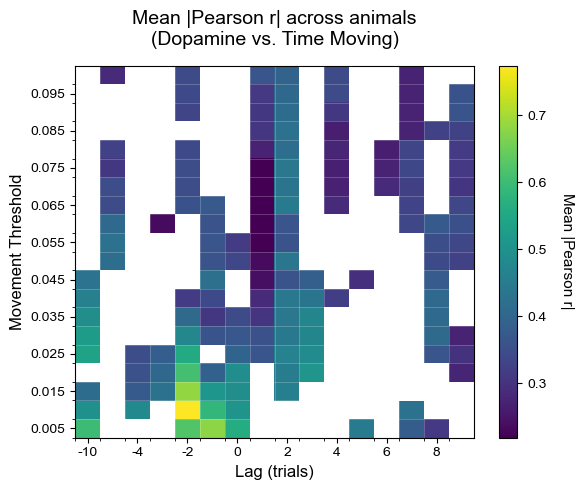


Global maximum (mean |r| across animals):
  Threshold: 0.0100
  Lag: -2 trials
  Mean |r|: 0.774


In [80]:
# Plot heatmap: mean |r| as a function of threshold and lag
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

# Create heatmap
im = ax.imshow(
    heatmap_data.values,
    aspect='auto',
    cmap='viridis',
    origin='lower',
    interpolation='nearest'
)

# Set axis labels and ticks
ax.set_xlabel('Lag (trials)', fontsize=12)
ax.set_ylabel('Movement Threshold', fontsize=12)
ax.set_title('Mean |Pearson r| across animals\n(Dopamine vs. Time Moving)', fontsize=14, pad=15)

# Set x-axis ticks to show lag values
lag_ticks = np.arange(len(heatmap_data.columns))
lag_labels = [int(x) for x in heatmap_data.columns]
ax.set_xticks(lag_ticks[::2])  # Show every other lag for readability
ax.set_xticklabels(lag_labels[::2])

# Set y-axis ticks to show threshold values
threshold_ticks = np.arange(len(heatmap_data.index))
threshold_labels = [f'{x:.3f}' for x in heatmap_data.index]
ax.set_yticks(threshold_ticks[::2])  # Show every other threshold for readability
ax.set_yticklabels(threshold_labels[::2])

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Mean |Pearson r|', rotation=270, labelpad=20, fontsize=11)

# Add grid for better readability
ax.set_xticks(lag_ticks - 0.5, minor=True)
ax.set_yticks(threshold_ticks - 0.5, minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.show()

# Find and highlight the global maximum
max_r_idx = np.unravel_index(np.nanargmax(heatmap_data.values), heatmap_data.shape)
max_threshold = heatmap_data.index[max_r_idx[0]]
max_lag = heatmap_data.columns[max_r_idx[1]]
max_r = heatmap_data.values[max_r_idx]

print(f"\nGlobal maximum (mean |r| across animals):")
print(f"  Threshold: {max_threshold:.4f}")
print(f"  Lag: {int(max_lag)} trials")
print(f"  Mean |r|: {max_r:.3f}")

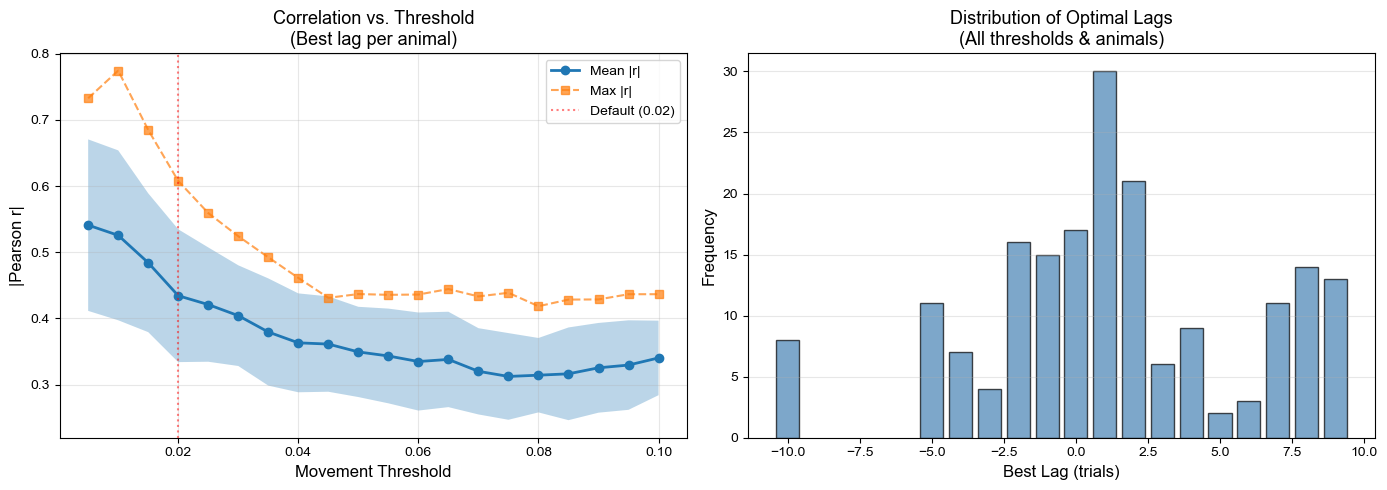


Summary Statistics:
  Default threshold (0.02) mean |r|: 0.434
  Optimal threshold: 0.0050
  Optimal threshold mean |r|: 0.541

Most common best lag: 1.0 trials (occurred 30 times)


In [81]:
# Additional visualization: Best correlation vs threshold (aggregated across lags)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: Mean and max |r| across animals for each threshold (taking best lag per animal)
threshold_summary = (
    grid_df
    .groupby('threshold')
    .agg({
        'best_abs_r': ['mean', 'std', 'max'],
        'animal': 'count'
    })
    .reset_index()
)
threshold_summary.columns = ['threshold', 'mean_abs_r', 'std_abs_r', 'max_abs_r', 'n_animals']

ax = axes[0]
ax.plot(threshold_summary['threshold'], threshold_summary['mean_abs_r'], marker='o', label='Mean |r|', linewidth=2)
ax.fill_between(
    threshold_summary['threshold'],
    threshold_summary['mean_abs_r'] - threshold_summary['std_abs_r'],
    threshold_summary['mean_abs_r'] + threshold_summary['std_abs_r'],
    alpha=0.3
)
ax.plot(threshold_summary['threshold'], threshold_summary['max_abs_r'], marker='s', linestyle='--', 
        label='Max |r|', linewidth=1.5, alpha=0.7)
ax.axvline(0.02, color='red', linestyle=':', alpha=0.5, label='Default (0.02)')
ax.set_xlabel('Movement Threshold', fontsize=12)
ax.set_ylabel('|Pearson r|', fontsize=12)
ax.set_title('Correlation vs. Threshold\n(Best lag per animal)', fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Panel 2: Distribution of best lags across all thresholds
ax = axes[1]
lag_counts = grid_df['best_lag'].value_counts().sort_index()
ax.bar(lag_counts.index, lag_counts.values, color='steelblue', edgecolor='black', alpha=0.7)
ax.set_xlabel('Best Lag (trials)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Optimal Lags\n(All thresholds & animals)', fontsize=13)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"  Default threshold (0.02) mean |r|: {threshold_summary.loc[threshold_summary['threshold'].sub(0.02).abs().idxmin(), 'mean_abs_r']:.3f}")
best_threshold_row = threshold_summary.loc[threshold_summary['mean_abs_r'].idxmax()]
print(f"  Optimal threshold: {best_threshold_row['threshold']:.4f}")
print(f"  Optimal threshold mean |r|: {best_threshold_row['mean_abs_r']:.3f}")
print(f"\nMost common best lag: {lag_counts.idxmax()} trials (occurred {lag_counts.max()} times)")

## Per-Animal Optimal Parameters

Identify the optimal threshold and lag for each individual animal based on maximum |Pearson r|.

In [82]:
# Find optimal threshold and lag for each animal
per_animal_optimal = []

for animal in animals_full:
    animal_grid_data = grid_df.query("animal == @animal")
    
    if len(animal_grid_data) == 0:
        continue
    
    # Find the row with maximum |r| for this animal
    best_idx = animal_grid_data['best_abs_r'].idxmax()
    best_row = animal_grid_data.loc[best_idx]
    
    per_animal_optimal.append({
        'animal': animal,
        'optimal_threshold': best_row['threshold'],
        'optimal_lag': best_row['best_lag'],
        'best_r': best_row['best_r'],
        'best_abs_r': best_row['best_abs_r'],
        'pvalue': best_row['pvalue']
    })

per_animal_df = pd.DataFrame(per_animal_optimal).sort_values('best_abs_r', ascending=False)

print("Optimal parameters for each animal (sorted by |r|):")
print("=" * 85)
print(per_animal_df.to_string(index=False))
print("\n" + "=" * 85)
print(f"\nSummary Statistics:")
print(f"  Mean optimal threshold: {per_animal_df['optimal_threshold'].mean():.4f}")
print(f"  Median optimal threshold: {per_animal_df['optimal_threshold'].median():.4f}")
print(f"  Std optimal threshold: {per_animal_df['optimal_threshold'].std():.4f}")
print(f"  Range: [{per_animal_df['optimal_threshold'].min():.4f}, {per_animal_df['optimal_threshold'].max():.4f}]")
print(f"\n  Mean optimal lag: {per_animal_df['optimal_lag'].mean():.2f} trials")
print(f"  Median optimal lag: {per_animal_df['optimal_lag'].median():.2f} trials")
print(f"  Std optimal lag: {per_animal_df['optimal_lag'].std():.2f} trials")
print(f"\n  Mean best |r|: {per_animal_df['best_abs_r'].mean():.3f}")
print(f"  Median best |r|: {per_animal_df['best_abs_r'].median():.3f}")

Optimal parameters for each animal (sorted by |r|):
animal  optimal_threshold  optimal_lag    best_r  best_abs_r       pvalue
  PB31              0.010         -2.0 -0.774240    0.774240 1.729434e-10
  PB73              0.005         -1.0 -0.624655    0.624655 2.083520e-06
  PB26              0.005         -2.0 -0.623906    0.623906 2.793139e-06
  PB75              0.010          0.0 -0.622288    0.622288 1.810496e-06
  PB72              0.005          0.0 -0.617633    0.617633 2.272164e-06
  PB30              0.005        -10.0 -0.598693    0.598693 5.669590e-05
  PB46              0.010          0.0 -0.534945    0.534945 7.497207e-05
  PB27              0.005          5.0 -0.447310    0.447310 2.332329e-03
  PB48              0.015         -3.0 -0.428238    0.428238 2.987679e-03
  PB71              0.010          0.0 -0.359519    0.359519 1.117685e-02


Summary Statistics:
  Mean optimal threshold: 0.0080
  Median optimal threshold: 0.0075
  Std optimal threshold: 0.0035
  Range: [0.

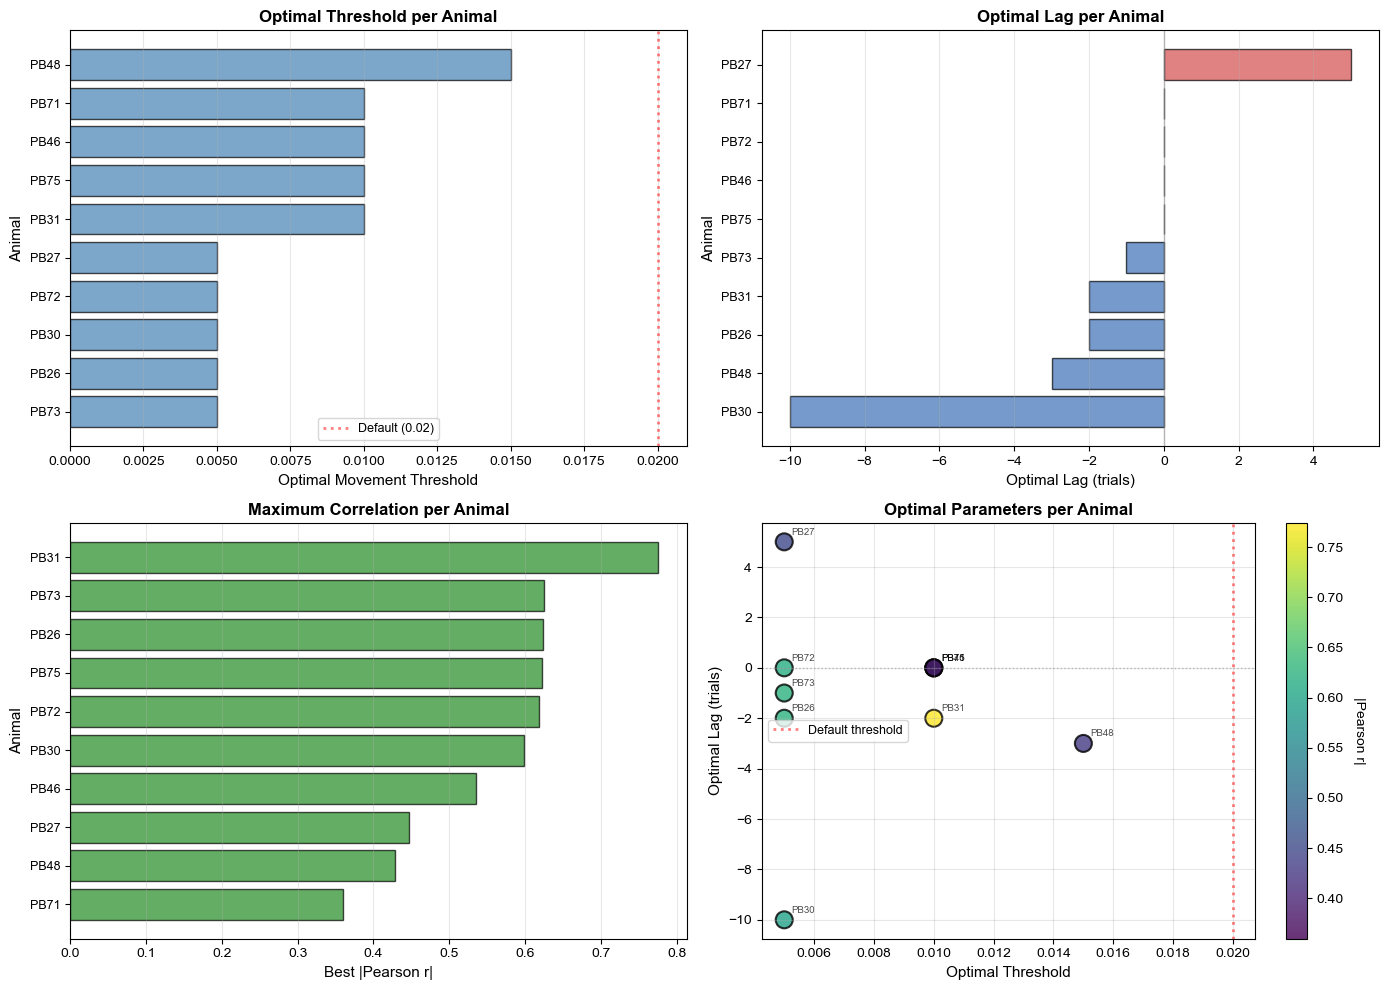

In [83]:
# Visualize per-animal optimal parameters
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel 1: Optimal threshold per animal
ax = axes[0, 0]
animal_sorted = per_animal_df.sort_values('optimal_threshold')
y_pos = np.arange(len(animal_sorted))
bars = ax.barh(y_pos, animal_sorted['optimal_threshold'], color='steelblue', alpha=0.7, edgecolor='black')
ax.axvline(0.02, color='red', linestyle=':', linewidth=2, alpha=0.5, label='Default (0.02)')
ax.set_yticks(y_pos)
ax.set_yticklabels(animal_sorted['animal'], fontsize=9)
ax.set_xlabel('Optimal Movement Threshold', fontsize=11)
ax.set_ylabel('Animal', fontsize=11)
ax.set_title('Optimal Threshold per Animal', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis='x')

# Panel 2: Optimal lag per animal
ax = axes[0, 1]
animal_sorted_lag = per_animal_df.sort_values('optimal_lag')
y_pos = np.arange(len(animal_sorted_lag))
colors_lag = ['#d34d4d' if lag > 0 else '#3b6fb6' if lag < 0 else '#9a9a9a' 
              for lag in animal_sorted_lag['optimal_lag']]
bars = ax.barh(y_pos, animal_sorted_lag['optimal_lag'], color=colors_lag, alpha=0.7, edgecolor='black')
ax.axvline(0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
ax.set_yticks(y_pos)
ax.set_yticklabels(animal_sorted_lag['animal'], fontsize=9)
ax.set_xlabel('Optimal Lag (trials)', fontsize=11)
ax.set_ylabel('Animal', fontsize=11)
ax.set_title('Optimal Lag per Animal', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Panel 3: Best |r| per animal
ax = axes[1, 0]
animal_sorted_r = per_animal_df.sort_values('best_abs_r')
y_pos = np.arange(len(animal_sorted_r))
bars = ax.barh(y_pos, animal_sorted_r['best_abs_r'], color='forestgreen', alpha=0.7, edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(animal_sorted_r['animal'], fontsize=9)
ax.set_xlabel('Best |Pearson r|', fontsize=11)
ax.set_ylabel('Animal', fontsize=11)
ax.set_title('Maximum Correlation per Animal', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Panel 4: Scatter plot - threshold vs lag colored by |r|
ax = axes[1, 1]
scatter = ax.scatter(
    per_animal_df['optimal_threshold'],
    per_animal_df['optimal_lag'],
    c=per_animal_df['best_abs_r'],
    s=150,
    cmap='viridis',
    edgecolor='black',
    linewidth=1.5,
    alpha=0.8
)
ax.axvline(0.02, color='red', linestyle=':', linewidth=2, alpha=0.5, label='Default threshold')
ax.axhline(0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
ax.set_xlabel('Optimal Threshold', fontsize=11)
ax.set_ylabel('Optimal Lag (trials)', fontsize=11)
ax.set_title('Optimal Parameters per Animal', fontsize=12, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('|Pearson r|', rotation=270, labelpad=15, fontsize=10)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Add animal labels to scatter plot
for idx, row in per_animal_df.iterrows():
    ax.annotate(
        row['animal'],
        (row['optimal_threshold'], row['optimal_lag']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=7,
        alpha=0.7
    )

plt.tight_layout()
plt.show()

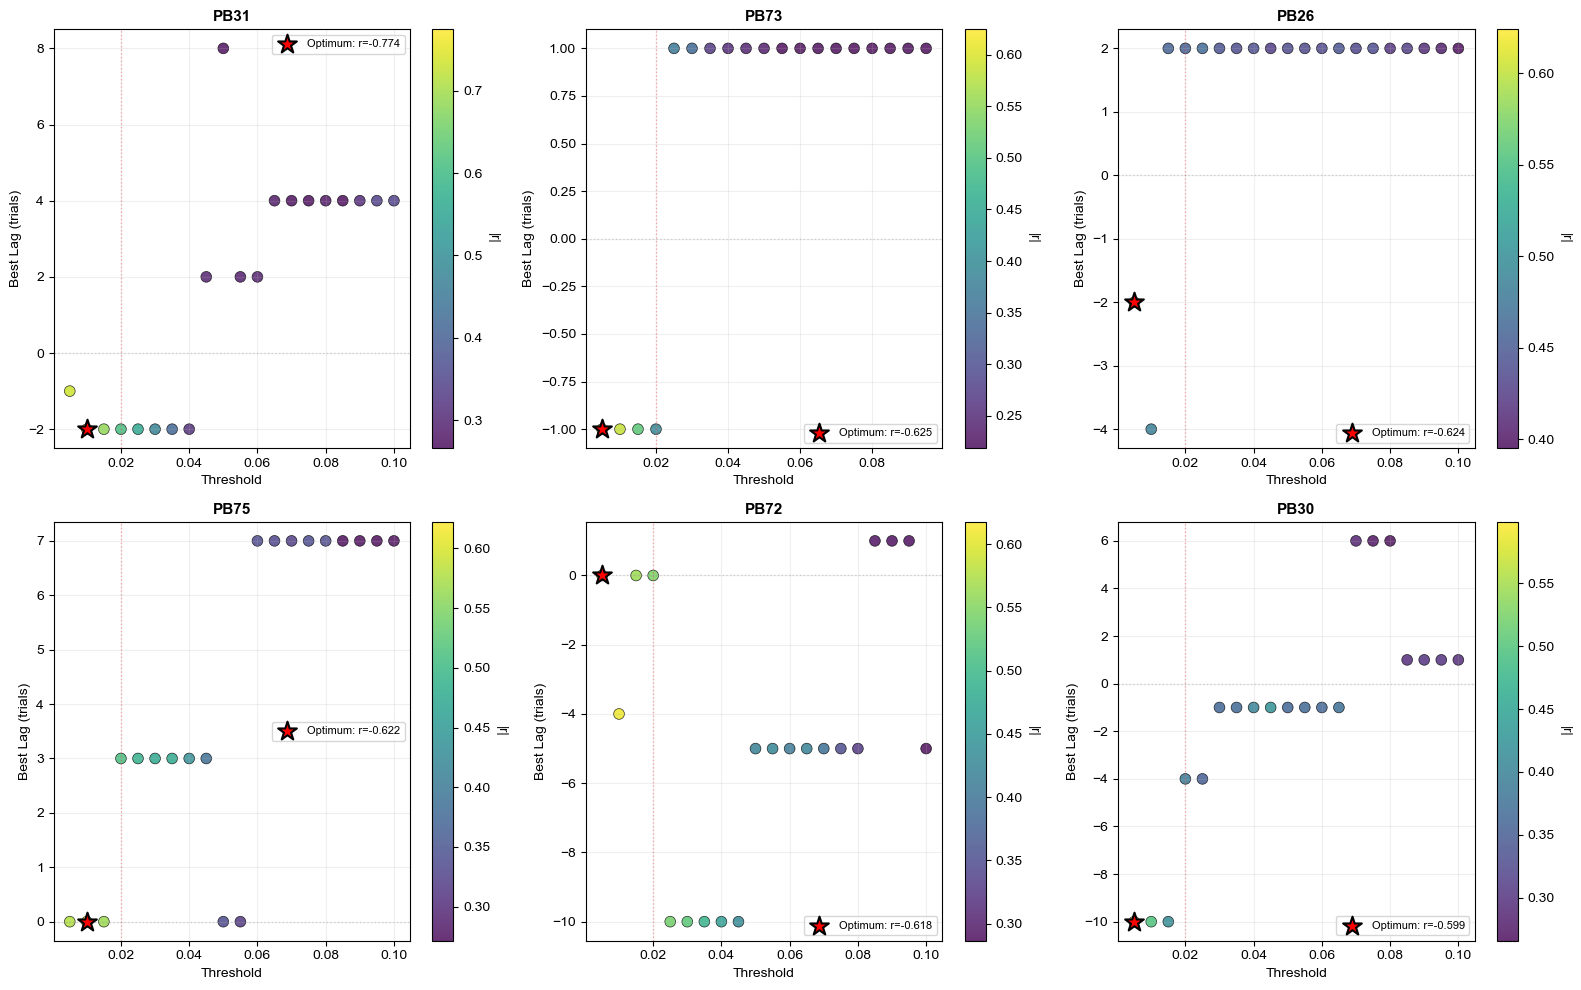

Showing correlation landscapes for top 6 animals by best |r|
Red star indicates the optimal (threshold, lag) combination for each animal


In [84]:
# Create individual heatmaps for selected animals showing correlation landscape
# Select top 6 animals by best |r| for visualization
top_animals = per_animal_df.head(6)['animal'].values

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, animal in enumerate(top_animals):
    ax = axes[idx]
    
    # Get all grid search results for this animal
    animal_data = grid_df.query("animal == @animal")
    
    # Create pivot table: threshold x lag -> |r|
    # For each threshold, we have one "best_lag", so need to expand to all lags
    # Actually, we need to recompute all lag correlations for each threshold
    # But that's stored in grid_df - grid_df has one row per (animal, threshold) with best_lag
    
    # For visualization, let's show threshold vs best_lag with color = |r|
    scatter = ax.scatter(
        animal_data['threshold'],
        animal_data['best_lag'],
        c=animal_data['best_abs_r'],
        s=60,
        cmap='viridis',
        edgecolor='black',
        linewidth=0.5,
        alpha=0.8
    )
    
    # Mark the global optimum for this animal
    animal_opt = per_animal_df.query("animal == @animal").iloc[0]
    ax.scatter(
        [animal_opt['optimal_threshold']],
        [animal_opt['optimal_lag']],
        s=200,
        marker='*',
        c='red',
        edgecolor='black',
        linewidth=1.5,
        zorder=10,
        label=f"Optimum: r={animal_opt['best_r']:.3f}"
    )
    
    ax.axvline(0.02, color='red', linestyle=':', linewidth=1, alpha=0.3)
    ax.axhline(0, color='gray', linestyle=':', linewidth=1, alpha=0.3)
    ax.set_xlabel('Threshold', fontsize=10)
    ax.set_ylabel('Best Lag (trials)', fontsize=10)
    ax.set_title(f'{animal}', fontsize=11, fontweight='bold')
    ax.legend(fontsize=8, loc='best')
    ax.grid(True, alpha=0.2)
    
    # Add colorbar for each subplot
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('|r|', rotation=270, labelpad=12, fontsize=9)

plt.tight_layout()
plt.show()

print(f"Showing correlation landscapes for top {len(top_animals)} animals by best |r|")
print("Red star indicates the optimal (threshold, lag) combination for each animal")

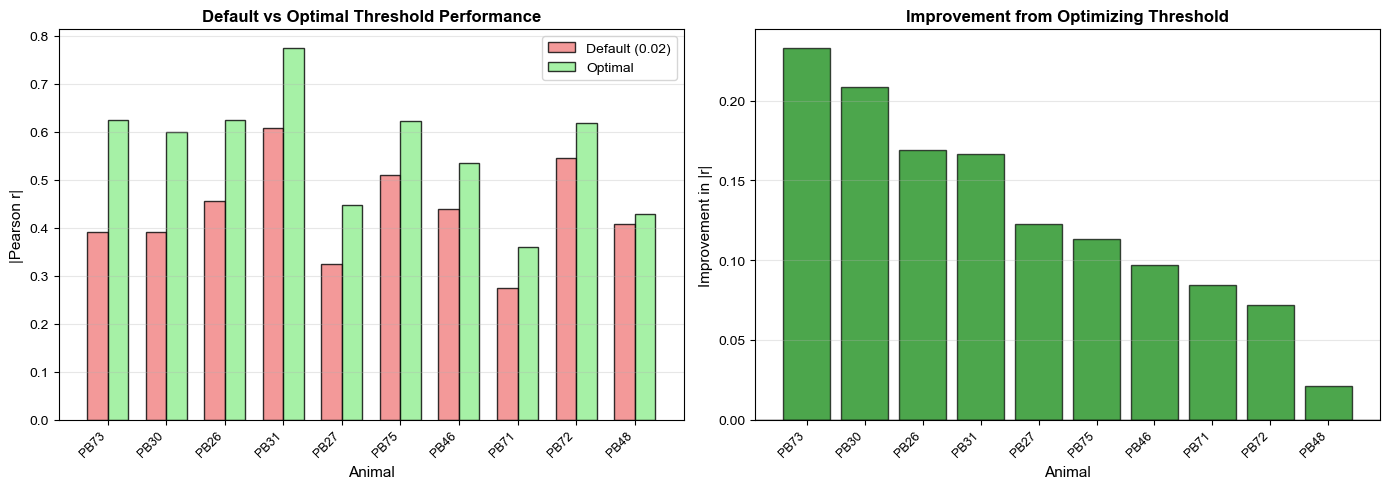

Comparison of Default (0.02) vs Optimal Threshold:
animal  default_r  default_lag  optimal_r  optimal_threshold  optimal_lag  improvement  pct_improvement
  PB73   0.391686         -1.0   0.624655              0.005         -1.0     0.232969        59.478358
  PB30   0.389946         -4.0   0.598693              0.005        -10.0     0.208747        53.532324
  PB26   0.454982          2.0   0.623906              0.005         -2.0     0.168924        37.127616
  PB31   0.607607         -2.0   0.774240              0.010         -2.0     0.166633        27.424553
  PB27   0.324417         -4.0   0.447310              0.005          5.0     0.122893        37.881364
  PB75   0.509032          3.0   0.622288              0.010          0.0     0.113256        22.249386
  PB46   0.438008          0.0   0.534945              0.010          0.0     0.096937        22.131381
  PB71   0.275048          9.0   0.359519              0.010          0.0     0.084470        30.711010
  PB72   0.54

In [85]:
# Compare default threshold (0.02) vs optimal threshold for each animal
comparison_data = []

for animal in animals_full:
    # Get optimal parameters
    opt_row = per_animal_df.query("animal == @animal")
    if len(opt_row) == 0:
        continue
    opt_row = opt_row.iloc[0]
    
    # Get performance at default threshold (0.02)
    default_data = grid_df.query("animal == @animal and threshold == 0.02")
    
    if len(default_data) > 0:
        default_r = default_data.iloc[0]['best_abs_r']
        default_lag = default_data.iloc[0]['best_lag']
    else:
        # Find closest threshold to 0.02
        animal_thresholds = grid_df.query("animal == @animal")
        closest_idx = (animal_thresholds['threshold'] - 0.02).abs().idxmin()
        default_r = animal_thresholds.loc[closest_idx, 'best_abs_r']
        default_lag = animal_thresholds.loc[closest_idx, 'best_lag']
    
    comparison_data.append({
        'animal': animal,
        'default_r': default_r,
        'default_lag': default_lag,
        'optimal_r': opt_row['best_abs_r'],
        'optimal_threshold': opt_row['optimal_threshold'],
        'optimal_lag': opt_row['optimal_lag'],
        'improvement': opt_row['best_abs_r'] - default_r,
        'pct_improvement': ((opt_row['best_abs_r'] - default_r) / default_r * 100) if default_r > 0 else 0
    })

comparison_df = pd.DataFrame(comparison_data).sort_values('improvement', ascending=False)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: Comparison of default vs optimal |r|
ax = axes[0]
x_pos = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x_pos - width/2, comparison_df['default_r'], width, 
               label='Default (0.02)', color='lightcoral', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x_pos + width/2, comparison_df['optimal_r'], width,
               label='Optimal', color='lightgreen', alpha=0.8, edgecolor='black')

ax.set_xlabel('Animal', fontsize=11)
ax.set_ylabel('|Pearson r|', fontsize=11)
ax.set_title('Default vs Optimal Threshold Performance', fontsize=12, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(comparison_df['animal'], rotation=45, ha='right', fontsize=9)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Panel 2: Improvement distribution
ax = axes[1]
improvements = comparison_df['improvement'].values
colors = ['green' if x > 0 else 'red' if x < 0 else 'gray' for x in improvements]
ax.bar(x_pos, improvements, color=colors, alpha=0.7, edgecolor='black')
ax.axhline(0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Animal', fontsize=11)
ax.set_ylabel('Improvement in |r|', fontsize=11)
ax.set_title('Improvement from Optimizing Threshold', fontsize=12, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(comparison_df['animal'], rotation=45, ha='right', fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary
print("Comparison of Default (0.02) vs Optimal Threshold:")
print("=" * 100)
print(comparison_df.to_string(index=False))
print("\n" + "=" * 100)
print(f"\nSummary:")
print(f"  Mean improvement: {comparison_df['improvement'].mean():.4f} (|r| units)")
print(f"  Median improvement: {comparison_df['improvement'].median():.4f}")
print(f"  Mean % improvement: {comparison_df['pct_improvement'].mean():.2f}%")
print(f"  Animals improved: {(comparison_df['improvement'] > 0).sum()} / {len(comparison_df)}")
print(f"  Animals worsened: {(comparison_df['improvement'] < 0).sum()} / {len(comparison_df)}")
print(f"  Max improvement: {comparison_df['improvement'].max():.4f} ({comparison_df.loc[comparison_df['improvement'].idxmax(), 'animal']})")

## Time Moving Trajectories with Optimal Thresholds

Visualize time_moving vs trial for each animal using their individualized optimal thresholds.

In [89]:
# Recalculate time_moving for each animal using their optimal threshold
optimal_time_moving_data = []

for idx, animal_opt in per_animal_df.iterrows():
    animal = animal_opt['animal']
    optimal_threshold = animal_opt['optimal_threshold']
    
    # Recalculate time_moving for entire x_array with optimal threshold
    x_array_with_optimal = recalculate_time_moving(
        x_array,
        snips_movement,
        threshold=optimal_threshold
    )
    
    # Get subset and animal's data
    subset_with_optimal = x_array_with_optimal.query("condition == 'deplete' & infusiontype == '45NaCl'")
    animal_data_optimal = subset_with_optimal.query("id == @animal").sort_values('trial').copy()
    
    # Get default data for comparison
    animal_data_default = subset_condition.query("id == @animal").sort_values('trial').copy()
    
    # Store for plotting
    optimal_time_moving_data.append({
        'animal': animal,
        'trials': animal_data_optimal['trial'].values,
        'time_moving_optimal': animal_data_optimal['time_moving'].values,
        'time_moving_default': animal_data_default['time_moving'].values,  # Original
        'optimal_threshold': optimal_threshold,
        'best_r': animal_opt['best_r']
    })

print(f"Recalculated time_moving for {len(optimal_time_moving_data)} animals using individualized thresholds")
print(f"Threshold range: [{per_animal_df['optimal_threshold'].min():.4f}, {per_animal_df['optimal_threshold'].max():.4f}]")

Recalculated time_moving for 10 animals using individualized thresholds
Threshold range: [0.0050, 0.0150]


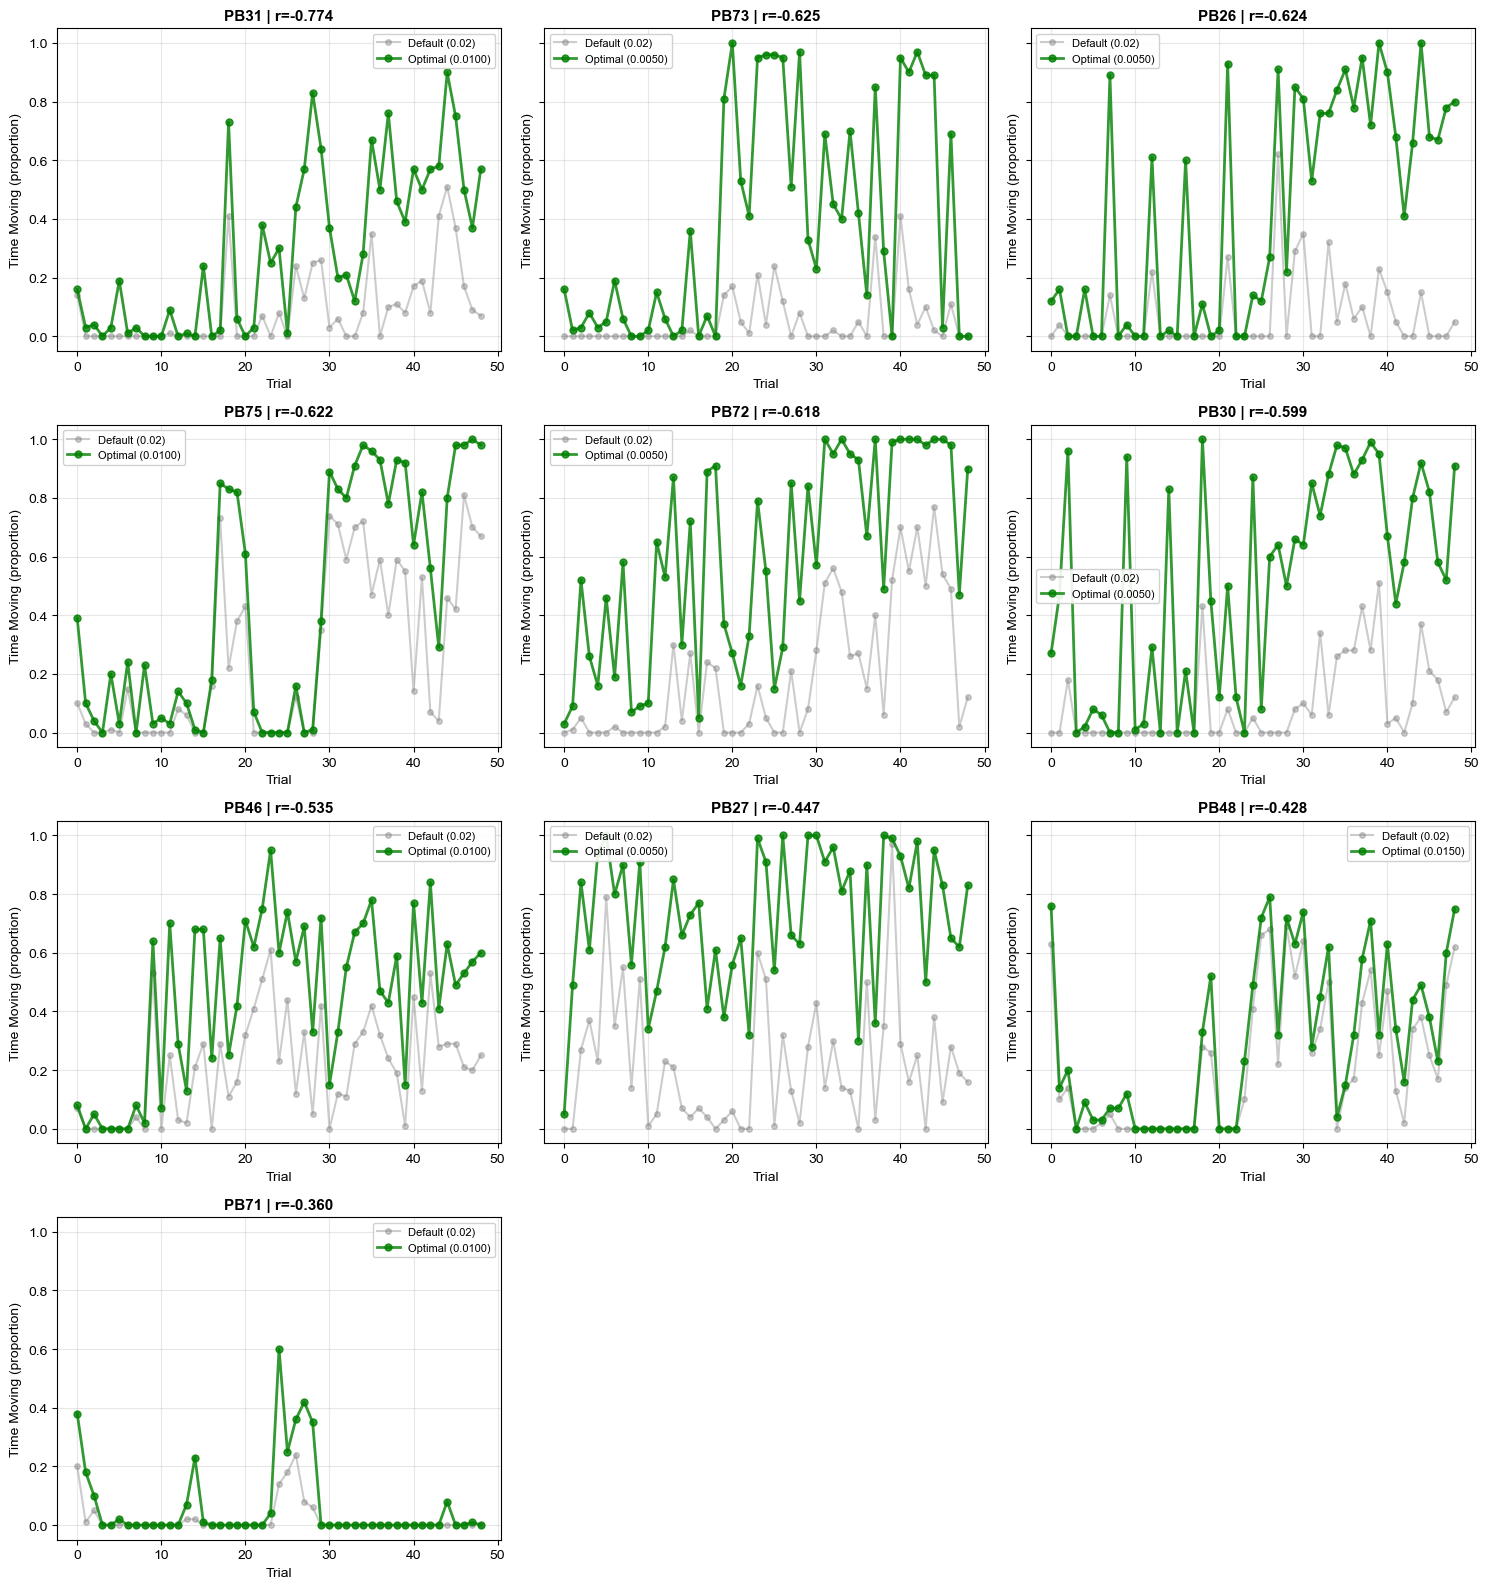


Showing time_moving trajectories for all 10 animals
Gray line: default threshold (0.02)
Colored line: individualized optimal threshold


In [93]:
# Plot time_moving vs trial for each animal using optimal thresholds
n_animals = len(optimal_time_moving_data)
n_cols = 3
n_rows = int(np.ceil(n_animals / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), sharex=False, sharey=True)
axes = axes.flatten() if n_animals > 1 else [axes]

for idx, animal_info in enumerate(optimal_time_moving_data):
    ax = axes[idx]
    
    animal = animal_info['animal']
    trials = animal_info['trials']
    time_moving_optimal = animal_info['time_moving_optimal']
    time_moving_default = animal_info['time_moving_default']
    optimal_threshold = animal_info['optimal_threshold']
    best_r = animal_info['best_r']
    
    # Plot both optimal and default for comparison
    ax.plot(trials, time_moving_default, 'o-', alpha=0.4, color='gray', 
            linewidth=1.5, markersize=4, label=f'Default (0.02)')
    ax.plot(trials, time_moving_optimal, 'o-', alpha=0.8, color=colors[1], 
            linewidth=2, markersize=5, label=f'Optimal ({optimal_threshold:.4f})')
    
    ax.set_xlabel('Trial', fontsize=10)
    ax.set_ylabel('Time Moving (proportion)', fontsize=10)
    ax.set_title(f'{animal} | r={best_r:.3f}', fontsize=11, fontweight='bold')
    ax.legend(fontsize=8, loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.05, 1.05)

# Hide unused subplots
for idx in range(n_animals, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print(f"\nShowing time_moving trajectories for all {n_animals} animals")
print("Gray line: default threshold (0.02)")
print("Colored line: individualized optimal threshold")

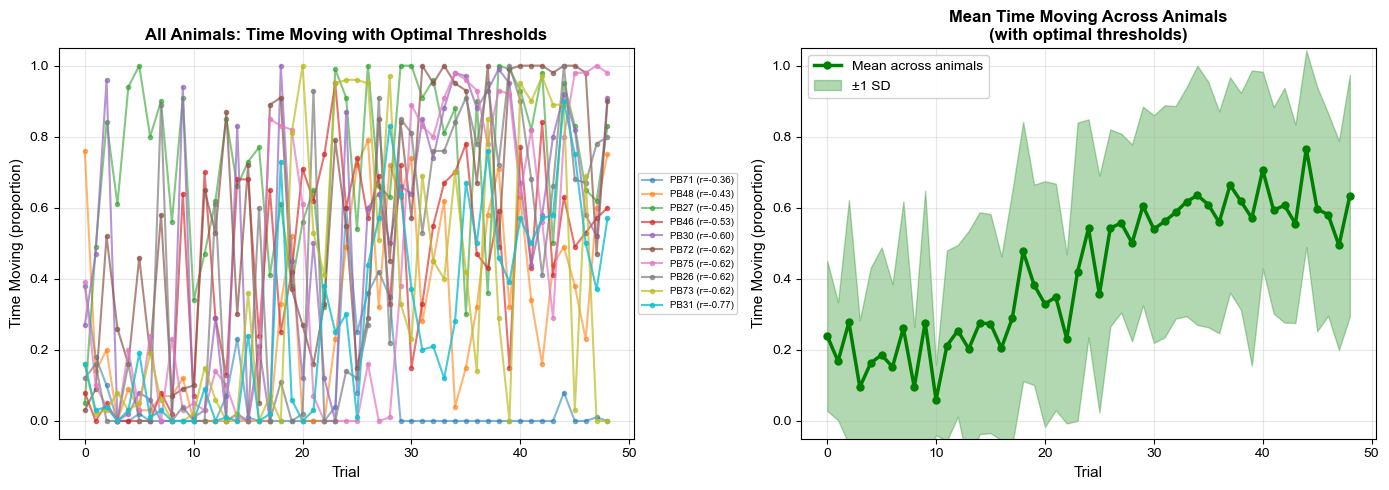

Left panel: Individual animals (opacity scaled by |r|)
Right panel: Population average ± SD


In [92]:
# Overlay plot: all animals' time_moving with optimal thresholds on one plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: All animals with optimal thresholds
ax = axes[0]
for animal_info in sorted(optimal_time_moving_data, key=lambda x: x['best_r'], reverse=True):
    trials = animal_info['trials']
    time_moving_optimal = animal_info['time_moving_optimal']
    animal = animal_info['animal']
    best_r = animal_info['best_r']
    
    # Color by correlation strength
    alpha = 0.3 + 0.5 * (abs(best_r) / per_animal_df['best_abs_r'].max())
    ax.plot(trials, time_moving_optimal, 'o-', alpha=alpha, linewidth=1.5, 
            markersize=3, label=f'{animal} (r={best_r:.2f})')

ax.set_xlabel('Trial', fontsize=11)
ax.set_ylabel('Time Moving (proportion)', fontsize=11)
ax.set_title('All Animals: Time Moving with Optimal Thresholds', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.05, 1.05)
ax.legend(fontsize=7, loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0.9)

# Panel 2: Mean ± SD across animals
ax = axes[1]

# Align all animals to common trial grid (use min and max trials)
all_trials = []
for animal_info in optimal_time_moving_data:
    all_trials.extend(animal_info['trials'])
trial_min, trial_max = min(all_trials), max(all_trials)
common_trials = np.arange(trial_min, trial_max + 1)

# Interpolate each animal's data to common trial grid
time_moving_matrix = []
for animal_info in optimal_time_moving_data:
    trials = animal_info['trials']
    time_moving = animal_info['time_moving_optimal']
    
    # Interpolate to common grid
    time_moving_interp = np.interp(common_trials, trials, time_moving, 
                                   left=np.nan, right=np.nan)
    time_moving_matrix.append(time_moving_interp)

time_moving_matrix = np.array(time_moving_matrix)

# Calculate mean and std across animals (ignoring NaNs)
mean_time_moving = np.nanmean(time_moving_matrix, axis=0)
std_time_moving = np.nanstd(time_moving_matrix, axis=0)

ax.plot(common_trials, mean_time_moving, 'o-', color=colors[0], linewidth=2.5, 
        markersize=5, label='Mean across animals')
ax.fill_between(common_trials, 
                mean_time_moving - std_time_moving,
                mean_time_moving + std_time_moving,
                color=colors[0], alpha=0.3, label='±1 SD')

ax.set_xlabel('Trial', fontsize=11)
ax.set_ylabel('Time Moving (proportion)', fontsize=11)
ax.set_title('Mean Time Moving Across Animals\n(with optimal thresholds)', fontsize=12, fontweight='bold')
ax.legend(fontsize=10, loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

print(f"Left panel: Individual animals (opacity scaled by |r|)")
print(f"Right panel: Population average ± SD")

## Time Moving Trajectories (Threshold = 0.005)

Visualize time_moving vs trial for each animal using a fixed threshold of 0.005.

In [94]:
# Recalculate time_moving using a fixed threshold for all animals
fixed_threshold = 0.005

x_array_fixed = recalculate_time_moving(
    x_array,
    snips_movement,
    threshold=fixed_threshold
)

subset_fixed = x_array_fixed.query("condition == 'deplete' & infusiontype == '45NaCl'")

best_r_by_animal = {}
if 'per_animal_df' in globals() and not per_animal_df.empty:
    best_r_by_animal = per_animal_df.set_index('animal')['best_r'].to_dict()

fixed_time_moving_data = []
for animal in animals_full:
    animal_data_fixed = subset_fixed.query("id == @animal").sort_values('trial').copy()
    if animal_data_fixed.empty:
        continue

    animal_data_default = subset_condition.query("id == @animal").sort_values('trial').copy()

    fixed_time_moving_data.append({
        'animal': animal,
        'trials': animal_data_fixed['trial'].values,
        'time_moving_fixed': animal_data_fixed['time_moving'].values,
        'time_moving_default': animal_data_default['time_moving'].values,
        'fixed_threshold': fixed_threshold,
        'best_r': best_r_by_animal.get(animal, np.nan)
    })

print(f"Recalculated time_moving for {len(fixed_time_moving_data)} animals using threshold={fixed_threshold}")

Recalculated time_moving for 10 animals using threshold=0.005


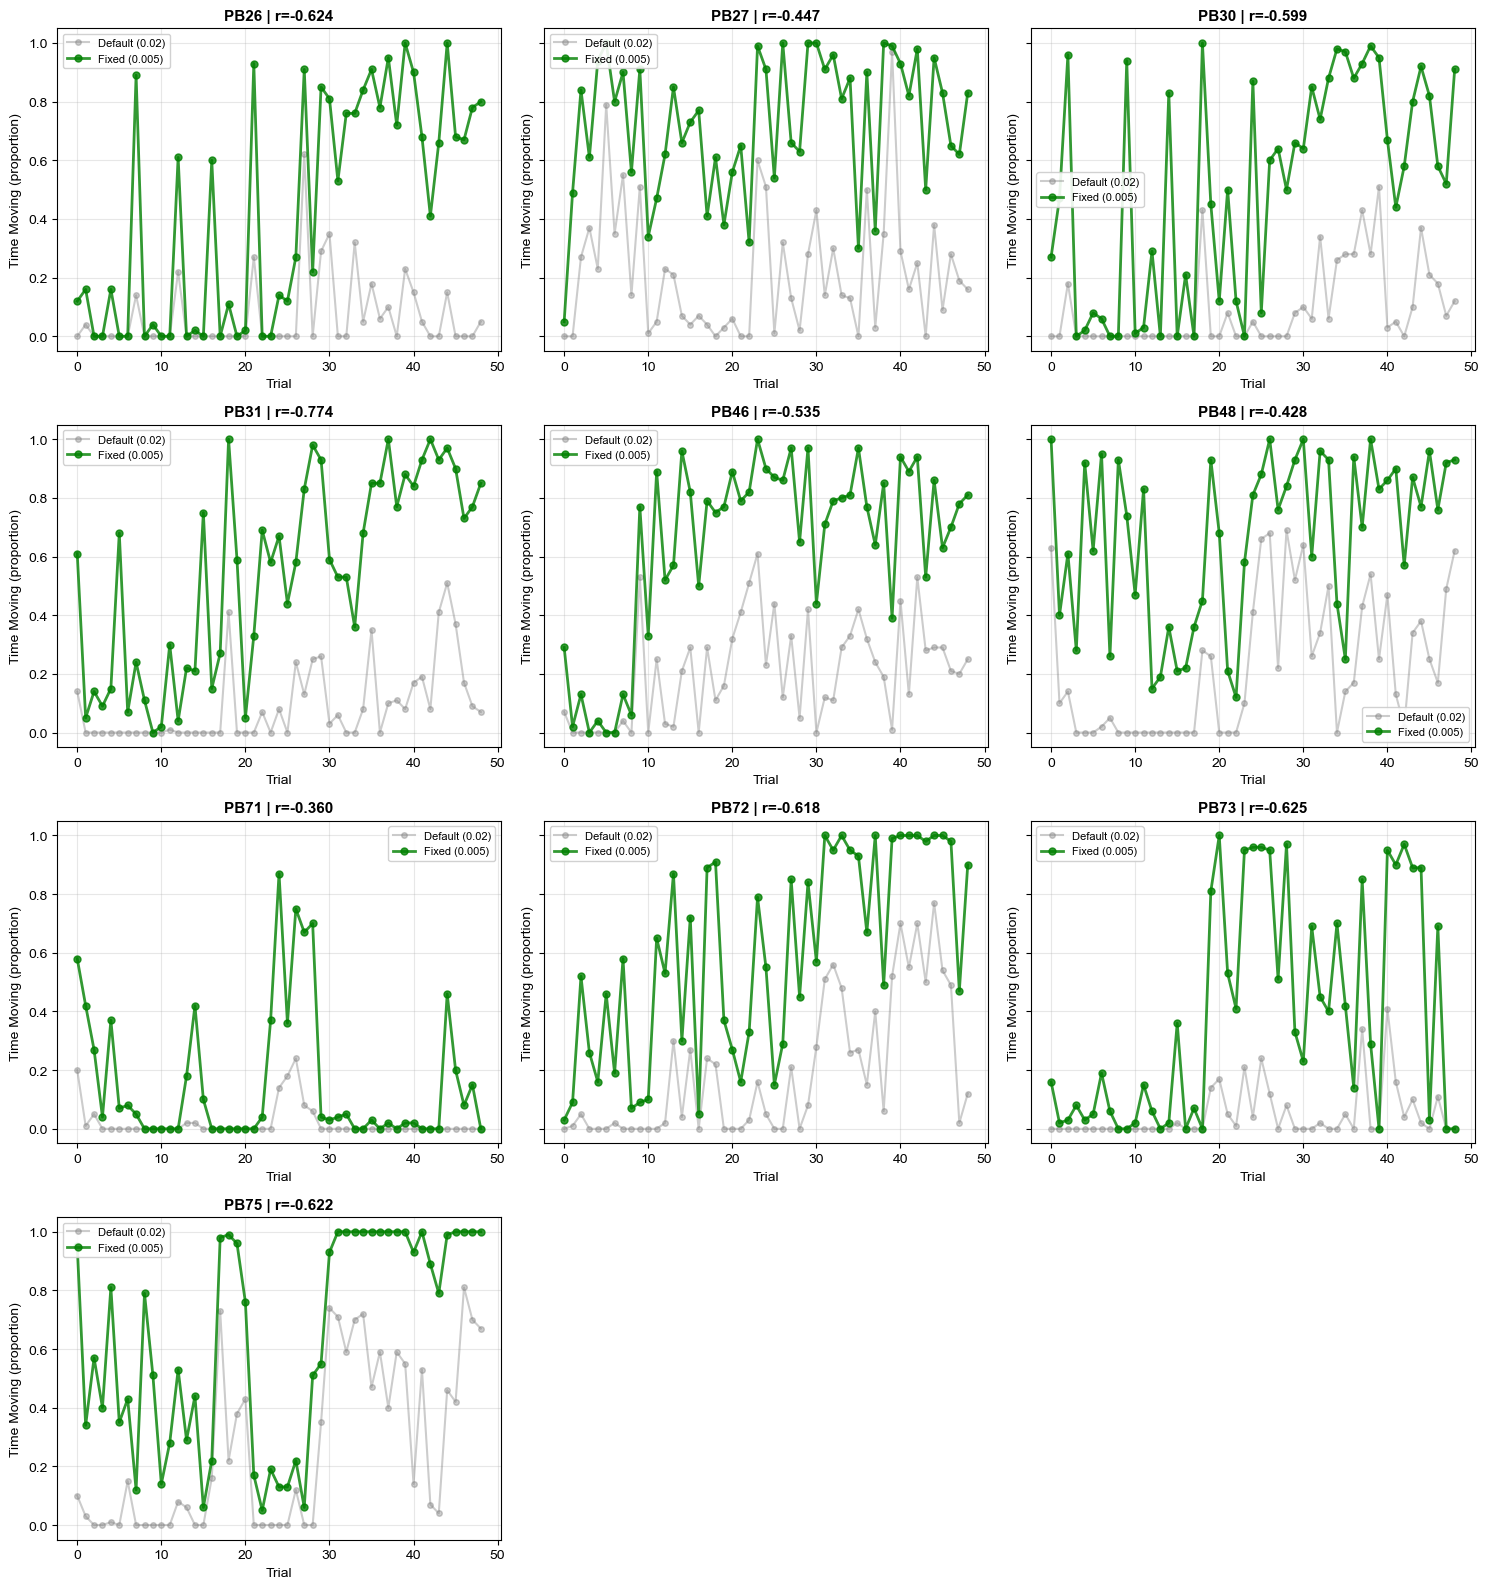


Showing time_moving trajectories for all 10 animals
Gray line: default threshold (0.02)
Colored line: fixed threshold (0.005)


In [95]:
# Plot time_moving vs trial for each animal using fixed threshold
n_animals_fixed = len(fixed_time_moving_data)
n_cols = 3
n_rows = int(np.ceil(n_animals_fixed / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), sharex=False, sharey=True)
axes = axes.flatten() if n_animals_fixed > 1 else [axes]

for idx, animal_info in enumerate(fixed_time_moving_data):
    ax = axes[idx]

    animal = animal_info['animal']
    trials = animal_info['trials']
    time_moving_fixed = animal_info['time_moving_fixed']
    time_moving_default = animal_info['time_moving_default']
    best_r = animal_info['best_r']

    # Plot both fixed threshold and default for comparison
    ax.plot(trials, time_moving_default, 'o-', alpha=0.4, color='gray',
            linewidth=1.5, markersize=4, label='Default (0.02)')
    ax.plot(trials, time_moving_fixed, 'o-', alpha=0.8, color=colors[1],
            linewidth=2, markersize=5, label=f'Fixed ({fixed_threshold:.3f})')

    title = f"{animal}"
    if np.isfinite(best_r):
        title += f" | r={best_r:.3f}"

    ax.set_xlabel('Trial', fontsize=10)
    ax.set_ylabel('Time Moving (proportion)', fontsize=10)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.legend(fontsize=8, loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.05, 1.05)

# Hide unused subplots
for idx in range(n_animals_fixed, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print(f"\nShowing time_moving trajectories for all {n_animals_fixed} animals")
print("Gray line: default threshold (0.02)")
print(f"Colored line: fixed threshold ({fixed_threshold:.3f})")

In [ ]:
# Overlay plot: all animals' time_moving with fixed threshold on one plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: All animals with fixed threshold
ax = axes[0]
for animal_info in sorted(fixed_time_moving_data, key=lambda x: (np.nan_to_num(x['best_r'], nan=0.0)), reverse=True):
    trials = animal_info['trials']
    time_moving_fixed = animal_info['time_moving_fixed']
    animal = animal_info['animal']
    best_r = animal_info['best_r']

    alpha_scale = np.nan_to_num(abs(best_r), nan=0.0)
    alpha = 0.3 + 0.5 * (alpha_scale / max(per_animal_df['best_abs_r'].max(), 1e-6))
    ax.plot(trials, time_moving_fixed, 'o-', alpha=alpha, linewidth=1.5,
            markersize=3, label=f'{animal} (r={best_r:.2f})' if np.isfinite(best_r) else animal)

ax.set_xlabel('Trial', fontsize=11)
ax.set_ylabel('Time Moving (proportion)', fontsize=11)
ax.set_title(f'All Animals: Time Moving (threshold={fixed_threshold:.3f})', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.05, 1.05)
ax.legend(fontsize=7, loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0.9)

# Panel 2: Mean ± SD across animals
ax = axes[1]

# Align all animals to common trial grid (use min and max trials)
all_trials = []
for animal_info in fixed_time_moving_data:
    all_trials.extend(animal_info['trials'])
trial_min, trial_max = min(all_trials), max(all_trials)
common_trials = np.arange(trial_min, trial_max + 1)

# Interpolate each animal's data to common trial grid
time_moving_matrix = []
for animal_info in fixed_time_moving_data:
    trials = animal_info['trials']
    time_moving = animal_info['time_moving_fixed']

    # Interpolate to common grid
    time_moving_interp = np.interp(common_trials, trials, time_moving,
                                   left=np.nan, right=np.nan)
    time_moving_matrix.append(time_moving_interp)

time_moving_matrix = np.array(time_moving_matrix)

# Calculate mean and std across animals (ignoring NaNs)
mean_time_moving = np.nanmean(time_moving_matrix, axis=0)
std_time_moving = np.nanstd(time_moving_matrix, axis=0)

ax.plot(common_trials, mean_time_moving, 'o-', color=colors[0], linewidth=2.5,
        markersize=5, label='Mean across animals')
ax.fill_between(common_trials,
                mean_time_moving - std_time_moving,
                mean_time_moving + std_time_moving,
                color=colors[0], alpha=0.3, label='±1 SD')

ax.set_xlabel('Trial', fontsize=11)
ax.set_ylabel('Time Moving (proportion)', fontsize=11)
ax.set_title('Mean Time Moving Across Animals\n(fixed threshold)', fontsize=12, fontweight='bold')
ax.legend(fontsize=10, loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

print("Left panel: Individual animals")
print("Right panel: Population average ± SD")